In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nen2018/NEN5060-2018.xlsx


In [2]:
!pip install gekko

     |████████████████████████████████| 10.8 MB 1.0 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO
import pandas as pd
import math
from pathlib import Path
import os

In [4]:
def qsun(tclim,
        Dh,
        En,
        gamma,
        beta,
        rground):
        """
        Calculates the solar irradiation on a outer surface.

        Parameters:
            tclim  (scalar):  time column vectors (sec) with one hour step size.
            Dh     (scalar):  diffuse horizontal irradiation[W/m2].
            En     (scalar):  direct normal irradiation [W/m2].
            gamma  (scalar):  the azimuth angle of the surface, east:gamma = -90, west:gamma = 90, south:gamma = 0, north:gamma = 180.
            beta   (scalar):  the inclination angle of the surface,horizontal: beta=0, vertical: beta=90
            rground:          ground reflection, 

            default geographical position: De Bilt default ground reflectivity (albedo): 0.2

            EXAMPLE: E=irrad(800,200,201,12,0,45) ANSWER: E=1.0e+003 * 0.8569 0.1907 1.0759 0.9684

        Return:  
            E : total irradiation on an inclined surface [w/m2]

        References: 
            - REF: Perez (zie Solar Energy volume 39 no. 3)
            - Adapted version from Eindhoven University of Technology: JvS feb 2002

        """
        iday = 1+math.floor(tclim/(24*3600)); """ iday (scalar):  day of the year (1-365)"""
        LST  = math.floor((tclim/3600) % 24); """ LST  (scalar):  Local Standard time (0 - 24) [hour]"""
        L    = 52.1;                          """ L:              Latitude [graden]"""
        LON  = 5.1;                           """ LON:            Local Longitude [graden] oost is positief"""
        LSM  = 15;                            """ LSM:            Local Standard time Meridian [graden] oost is positief"""
        """
            rground = albedo
            rground=0.2;
        """ 
        r    = math.pi/180;
        L    = L*r
        beta = beta*r
        theta= 2*math.pi*(iday-1)/365.25
        el   = 4.901+0.033*math.sin(-0.031+theta)+theta
        
        """declination"""

        delta= math.asin(math.sin(23.442*r)*math.sin(el))
        q1   = math.tan(4.901+theta)
        q2   = math.cos(23.442*r)*math.tan(el)
        
        """equation of time"""

        ET   = (math.atan((q1-q2)/(q1*q2+1)))*4/r
        AST  = LST+ET/60-(4/60)*(LSM-LON)
        h    = (AST-12)*15*r
        
        """hai: sin(solar altitude)""" 
        
        hai  = math.cos(L)*math.cos(delta)*math.cos(h)+math.sin(L)*math.sin(delta)
               
        E    = np.zeros((1,4))
        
        if hai>0:
            """salt: solar altitude"""
            salt= math.asin(hai) 
            phi = math.acos((hai*math.sin(L)-math.sin(delta))/(math.cos(salt)*math.cos(L)))*np.sign(h)
            gam = phi-gamma*r;
            
            """cai: cos(teta)"""
            
            cai = math.cos(salt)*math.cos(abs(gam))*math.sin(beta)+hai*math.cos(beta)
            """teta: incident angle on the tilted surface"""
            teta= math.acos(cai)
            
            """salts: solar altitude for an inclined surface"""

            salts=math.pi/2-teta
            
            """Perez (zie Solar Energy volume 39 no. 3),
            Calculation of the diffuse radiation on an oblique plane
            Approximatin of A and C, the solid angles occupied by the circumsolar region,
            weighed by its average incidence on the slope and horizontal respectively.
            In the expression of diffuse on inclined surface the quotient of A/C is
            reduced to XIC/XIH. A=2*(1-cos(beta))*xic, C=2*(1-cos(beta))*xih
            gecontroleerd okt 1996 martin de wit
            """
            
            # alpha= the half-angle circumsolar region
            alpha=25*r

            if salts<-alpha:

                xic=0

            elif salts>alpha:

                xic=cai


            else:
                xic=0.5*(1+salts/alpha)*math.sin((salts+alpha)/2)

            if salt>alpha:

                xih=hai

            else:
                xih=math.sin((alpha+salt)/2)

            """
            
            - (f1acc): circumsolar brightness coefficient
              
            - (f2acc): horizon brightness coefficient 
            
            """
            epsint=[1.056 ,1.253 ,1.586, 2.134, 3.23 ,5.98, 10.08 ,999999]
            f11acc=[-0.011 ,-0.038 ,0.166 ,0.419 ,0.710 ,0.857 ,0.734 ,0.421]
            f12acc=[0.748 ,1.115 ,0.909 ,0.646 ,0.025 ,-0.370 ,-0.073 ,-0.661]
            f13acc=[-0.080 ,-0.109 ,-0.179 ,-0.262 ,-0.290 ,-0.279 ,-0.228 ,0.097]
            f21acc=[-0.048 ,-0.023 ,0.062 ,0.140 ,0.243 ,0.267 ,0.231 ,0.119]
            f22acc=[0.073 ,0.106 ,-0.021 ,-0.167 ,-0.511 ,-0.792 ,-1.180 ,-2.125]
            f23acc=[-0.024 ,-0.037 ,-0.050 ,-0.042 ,-0.004 ,0.076 ,0.199 ,0.446]
            
            """Determination of zet = solar zenith angle (pi/2 - solar altitude)"""
            
            zet=math.pi/2-salt
            
            """Determination of inteps with eps"""

            inteps=0

            if Dh>0:

                eps=1+En/Dh
                inteps=7;                         """ give big random number for starting point"""
                for i in range(len(epsint)):
                    if epsint[i]>=eps:
                        temp_i =i        
                        inteps=min(temp_i,inteps)
                #print(inteps)                
                #inteps=min(i)

            """calculation of inverse relative air mass"""

            airmiv=hai

            if salt<10*r:
                airmiv=hai+0.15*(salt/r+3.885)**(-1.253)   # change ^ to **
            
            """calculation of extraterrestrial radiation""" 

            Eon=1370*(1+0.033*math.cos(2*math.pi*(iday-3)/365))
            
            """Delta is the new sky brightness parameter"""

            delta=Dh/(airmiv*Eon)

            """
            Determination of the new circumsolar brightness coefficient
              
            (f1acc) and horizon brightness coefficient (f2acc)
            
            """ 
            
            f1acc=f11acc[inteps]+f12acc[inteps]*delta+f13acc[inteps]*zet
            f2acc=f21acc[inteps]+f22acc[inteps]*delta+f23acc[inteps]*zet
            
            """Determination of the diffuse radiation on an inclined surface"""

            E[0,0]=Dh*(0.5*(1+math.cos(beta))*(1-f1acc)+f1acc*xic/xih+f2acc*math.sin(beta))

            if E[0,0]<0:

                E[0,0]=0

            """
                horizontal surfaces treated separately 
                beta=0 :       surface facing up, 
                beta=180(pi) : surface facing down
                
            """ 
            
            if beta>-0.0001 and beta<0.0001:

                E[0,0]=Dh

            if beta>(math.pi-0.0001) and beta<(math.pi+0.0001):

                E[0,0]=0
                
             # Isotropic sky
             # E(1)=0.5*(1+cos(beta))*Dh;

            """Direct solar radiation on a surface""" 

            E[0,1]=En*cai

            if E[0,1]<0.0:

                E[0,1]=0

            """The ground reflected component: assume isotropic ground conditions."""

            Eg=0.5*rground*(1-math.cos(beta))*(Dh+En*hai)
            
            """Global irradiation"""

            E[0,3]=Dh+En*hai

            """Total irradiation on an inclined surface"""
                
            E[0,2]=E[0,0] + E[0,1] + Eg
            
        return E[0,2]
        

> ### Change working directory to input data file

In [5]:
print(Path.cwd())
#print(os.listdir("../kaggle/input"))
parent_dir = os.chdir('/kaggle/')
data_dir = Path.cwd() /'input/nen2018'
#output_dir = Path.cwd()/'working'/'submit'
NENdata_path = data_dir/'NEN5060-2018.xlsx'
xls = pd.ExcelFile(NENdata_path)    

/kaggle/working


In [6]:
xls.sheet_names  # Check sheet names

['nen5060 - energie', 'ontwerp 1%', 'ontwerp 5%']

In [7]:
"""Select sheet in NEN data files.

     - k=1 by NEN default by default
     - k=2,3 for building construction purposes read NEN docs for more info.

"""
k=1

In [8]:
""" Exchange of NEN5060 data in climate files for Python

    Exchange of NEN5060_2018 data in Excel
    For irradiation on S, SW, W, NW, N, NE, E, SE and horizontal and Toutdoor
    Irradiation can be used for solar irradiation on windows
    Matlab version September 17th 2018 by Arie Taal THUAS (The Hague University of Applied Sciences)
    Python version 28/05/2020 by Trung Nguyen HAN University of Applied Sciences

"""


rground=0  #ground reflection is ignored

if k==1:
    NUM = pd.read_excel(xls,'nen5060 - energie');  """this file is part of NEN 5060 20018"""
elif k==2:
    NUM = pd.read_excel(xls,'ontwerp 1%')
elif k==3:
    NUM = pd.read_excel(xls,'ontwerp 5%')
#Convert data frame to array
to_array=NUM.to_numpy()
to_array=np.delete(to_array, 0, 0)
    
t=(np.array(list(range(1,8761)))-1)*3600
"""Day of month """
dom=to_array[:,2]
"""Hour of day"""
hod=to_array[:,3]                               
qglob_hor=to_array[:,4]
qdiff_hor=to_array[:,5]
qdir_hor=to_array[:,6]
qdir_nor=to_array[:,7]
Toutdoor=to_array[:,8]/10
phioutdoor=to_array[:,9]
xoutdoor=to_array[:,10]/10
"""% at 10 m height """  
pdamp=to_array[:,11]
vwind=to_array[:,12]/10                          
dirwind=to_array[:,13]
cloud=to_array[:,14]/10
rain=to_array[:,15]/10
    
#w, h = 9, 8760;
#E=[[0 for x in range(w)] for y in range(h)]
E= np.zeros((8760,9))
for j in range(9):
    if j<9:
        gamma=45*(j-1)
        beta=90
    else:
            
        gamma=90
        beta=0
        
    for i in range(8759):
            
        #E[i][j]=qsun(t[i],qdiff_hor[i],qdir_nor[i],gamma,beta,rground)
        E[i,j]=qsun(t[i],qdiff_hor[i],qdir_nor[i],gamma,beta,rground)
myarray = np.asarray(E)       
#myarray = np.delete(myarray,8759, 0)        
qsunS=np.vstack((t,myarray[:,0]))
qsunSW=np.vstack((t,myarray[:,1]))
qsunW=np.vstack((t,myarray[:,2]))
qsunNW=np.vstack((t,myarray[:,3]))
qsunN=np.vstack((t,myarray[:,4]))
qsunNE=np.vstack((t,myarray[:,5]))
qsunE=np.vstack((t,myarray[:,6]))
qsunSE=np.vstack((t,myarray[:,7]))
qsunhor=np.vstack((t,myarray[:,8]))
Tout=np.vstack((t,Toutdoor))
phiout=np.vstack((t,phioutdoor))
xout=np.vstack((t,xoutdoor))
pout=np.vstack((t,pdamp))
vout=np.vstack((t,vwind))
dirvout=np.vstack((t,dirwind))
cloudout=np.vstack((t,cloud))
rainout=np.vstack((t,rain))    
            

In [9]:
#Np.newaxis convert an 1D array to either a row vector or a column vector.
"""Create 2D array from 1D array with 2 elements"""
qsunS=qsunS[np.newaxis]     
qsunSW=qsunSW[np.newaxis]     
qsunW=qsunW[np.newaxis]     
qsunNW=qsunNW[np.newaxis]     
qsunN=qsunN[np.newaxis]     
qsunNE=qsunNE[np.newaxis]     
qsunE=qsunE[np.newaxis]     
qsunSE=qsunSE[np.newaxis]     
qsunhor=qsunhor[np.newaxis]     
Tout=Tout[np.newaxis]     
phiout=phiout[np.newaxis]     
xout=xout[np.newaxis]     
pout=pout[np.newaxis]     
vout=vout[np.newaxis]     
dirvout=dirvout[np.newaxis]     
cloudout=cloudout[np.newaxis]     
rainout=rainout[np.newaxis]        

In [10]:
"""Transpose array"""
qsunS=qsunS.T
qsunSW=qsunSW.T
qsunW=qsunW.T
qsunNW=qsunNW.T
qsunN=qsunN.T
qsunNE=qsunNE.T
qsunE=qsunE.T
qsunSE=qsunSE.T
qsunhor=qsunhor.T
Tout=Tout.T
phiout=phiout.T
xout=xout.T
pout=pout.T
vout=vout.T
dirvout=dirvout.T
cloudout=cloudout.T
rainout=rainout.T   

In [11]:
T_outdoor=Tout[:,1]

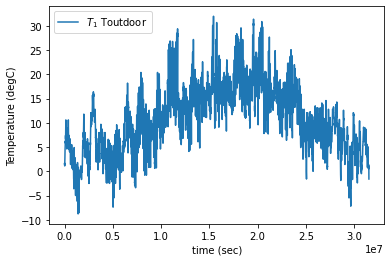

In [12]:
#numrows = len(input)    # 3 rows in your example
#numcols = len(input[0]) # 2 columns in your example

plt.plot(Tout[:,0],Toutdoor,label=r'$T_1$ Toutdoor')
plt.ylabel('Temperature (degC)')
plt.xlabel('time (sec)')
plt.legend(loc=2)

In [13]:
import gc
gc.collect() # collect garbages

8832

### Define input parameters

In [14]:
"""window surface in m2: [S SW W NW N NE E SE]"""
glass=[9.5,9.5,0,0,0,0,0,0]
"""Window solar transmitance, g-value"""
g_value =0.7
"""Time base on 1 hour sampling from NEN"""
time=qsunS[:,0]

In [15]:
print(len(time))

8760


1
8760


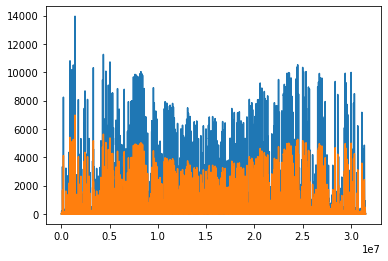

In [16]:
Qsolar = (qsunS[:,1]*glass[0] + qsunSW[:,1]*glass[1] + 
                      qsunW[:,1]*glass[2] + qsunNW[:,1]*glass[3] + 
                      qsunN[:,1]*glass[4] + qsunNE[:,1]*glass[5] + 
                      qsunE[:,1]*glass[6] + qsunSE[:,1]*glass[7]) * g_value
print(len(Qsolar[0]))
print(len(Qsolar))
plt.plot(time,Qsolar)
Qsolar = Qsolar/2
plt.plot(time,Qsolar)

### Internal heat gain 

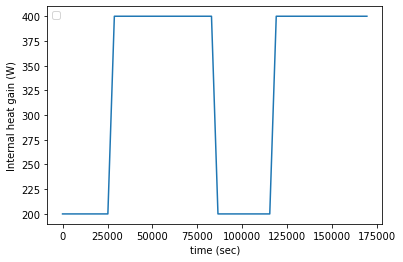

In [17]:
from scipy import signal

DeltaQ     = 200                     #Internal heat gain difference between day and night
#day_DeltaQ = DeltaQ                 #Day Delta Q internal [W]
Qday       = 400                     #Day internal heat gain W
nightQ     = Qday - DeltaQ           #Night internal heat gain

t1= 8                                #Presence from [hour]
t2= 23                               #Presence until [hour]

days_hours   = 24                    #number_of_hour_in_oneday + start hour at 0
days         = 365                   #number of simulation days
periods      = 24*3600*days          #in seconds (day_periods*365 = years)
pulse_width  = (t2-t1)/24            # % of the periods
phase_delay  = t1                    #in seconds


#t = np.linspace(0, 24*3600, 24)
t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0
pulseday = signal.square(2 * np.pi* days * t,duty=pulse_width)
pulseday = np.clip(pulseday, 0, 1)
# add delay to array
pulseday=np.roll(pulseday,phase_delay)

#______pulse week generator______________

week = days/7
pulse_w  = 0.99

#t = np.linspace(0, 24*3600, 24)
pulse_week = signal.square(2*np.pi*week*t,duty=pulse_w)
pulse_week = np.clip(pulse_week, 0, 1)

#pulse_week=np.roll(pulse_week,phase_delay)

#create simulation time
time_t = np.linspace(0,periods,(days_hours*days)+1)

#Internal heat gain

Qinternal = nightQ + pulseday*DeltaQ*pulse_week
Qinternal=Qinternal[np.newaxis]
Qinternal=Qinternal.T

#Plot 48 hours

plt.plot(time_t[0:48], Qinternal[0:48])
plt.ylabel('Internal heat gain (W)')
plt.xlabel('time (sec)')
plt.legend(loc=2)
#print(Qinternal)
Qinternal=np.delete(Qinternal, -1, 0)

In [18]:
""" Initialization Dwelling
      
        - Arie Taal, Baldiri Salcedo HHS 10 July 2018
        - The incident solar heat is divided between Cwall and Cair by the convection factor (CF=0.8)
        - Qinst :  isntant  by heating or cooling needed at this moments
        
        Last modify by Trung Nguyen
"""

"""Envelope surface (facade + roof + ground) [m2]"""
A_facade = 160.2
"""Envelope thermal resitance, R-value [m2/KW]"""
Rc_facade =1.3

"""
- Windows surface [N,S,E,W,SE,SW,NE,NW] [m2]
- glass =[0,0,9.5,9.5,0,0,0,0]
- Window thermal transmittance, U-value [W/m2K]
"""

Uglass = 2.9
"""Window solar transmitance, g-value"""
g_value =0.7
CF=0.8
"""Ventilation, air changes per hour [#/h]"""
n=0.55
"""Internal volume [m3]"""
V_dwelling = 275.6
"""Facade construction

    - Middle_weight =2 Light_weight =1 / Heavy_weight
"""
N_facade  = 2
"""Floor and internal walls surface [m2]"""
A_internal_mass = 170
"""Floor and internal walls construction

    - Middle_weight =2 / Light_weight=1 / Heavy_weight

"""
N_internal_mass = 2             


# House model Initial Parameters

In [19]:
N_internal_mass = 2;   """1: Light weight construction / 2: Middle weight construction / 3: Heavy weight construction""" 
N_facade = 2;          """1: Light weight construction / 2: Middle weight construction / 3: Heavy weight construction"""

'1: Light weight construction / 2: Middle weight construction / 3: Heavy weight construction'

In [20]:
"""Initial parameters file for House model"""

##Predefined variables 
 
rho_air = 1.20;              """Density air in [kg/m3] """
c_air  = 1005;               """Specific heat capacity air [J/kgK] """ 
alpha_i_facade = 8;
alpha_e_facade = 23;
alpha_internal_mass = 8;

""" 
Variables from Simulink model, dwelling mask
Floor and internal walls construction.
It is possible to choose between light, middle or heavy weight construction

"""

#Light weight construction  
if N_internal_mass==1:          
    
    c_internal_mass=840;         """Specific heat capacity construction [J/kgK] """
    th_internal_mass=0.1;        """Construction thickness [m] """
    rho_internal_mass=500;       """Density construction in [kg/m3] """
    
#Middle weight construction      
elif N_internal_mass==2:        
    
    c_internal_mass=840;        """Specific heat capacity construction [J/kgK] """
    th_internal_mass=0.1;       """Construction thickness [m] """
    rho_internal_mass=1000;     """Density construction in [kg/m3] """

#Heavy weight construction    
else:                          
         
    c_internal_mass=840;        """Specific heat capacity construction [J/kgK] """
    th_internal_mass=0.2;       """Construction thickness [m] """
    rho_internal_mass=2500;     """Density construction in [kg/m3]   """ 

"""Facade construction

    It is possible to choose between light, middle or heavy weight construction
"""

#Light weight construction   
if N_facade==1:               
    
    c_facade=840;             """Specific heat capacity construction [J/kgK] """
    rho_facade=500;           """Density construction in [kg/m3] """
    th_facade=0.1;            """Construction thickness [m] """ 
#Middle weight construction 
elif  N_facade==2:                 
    
    c_facade=840;             """Specific heat capacity construction [J/kgK] """
    rho_facade=1000;          """Density construction in [kg/m3] """
    th_facade=0.1;            """Construction thickness [m] """

#Heavy weight construction 
else:                        
    
    c_facade=840;             """Specific heat capacity construction [J/kgK] """
    rho_facade=2500;          """Density construction in [kg/m3] """
    th_facade=0.2;            """Construction thickness [m] """


Aglass=sum(glass);             """Sum of all glass surfaces [m2] """

"""Volume floor and internal walls construction [m3] 
    
    A_internal_mass:  Floor and internal walls surface [m2] 
"""
V_internal_mass=A_internal_mass*th_internal_mass  

""" n: ventilation air change per hour;  
    V_dwelling : internal volume m3 """

qV=(n*V_dwelling)/3600;            """Ventilation, volume air flow [m3/s] """ 
qm=qV*rho_air;                    """Ventilation, mass air flow [kg/s] """

""" 
Dwelling temperatures calculation
Calculation of the resistances
"""
Rair_wall=1/(A_internal_mass*alpha_internal_mass);  """Resistance indoor air-wall """
U=1/(1/alpha_i_facade+Rc_facade+1/alpha_e_facade);  """U-value indoor air-facade """
Rair_outdoor=1/(A_facade*U+Aglass*Uglass+qm*c_air); """Resitance indoor air-outdoor air """

"""Calculation of the capacities """
Cair = rho_internal_mass*c_internal_mass*V_internal_mass+ rho_air*c_air*V_dwelling; """Capacity indoor air + walls """
Cwall= rho_internal_mass*c_internal_mass*V_internal_mass;                           """Capacity walls """


'Capacity walls '

In [21]:
print(rho_internal_mass)
print (Cwall)
print (Rair_wall)
print (Rair_outdoor)
print(Cair)

1000
14280000.0
0.0007352941176470588
0.004651772409663865


> ## Define Temperature SP
    > Assume that in normal working day, people wake up at 7.00, go to work at 8.00
    return home at 18.00 and go to sleep at 23.00

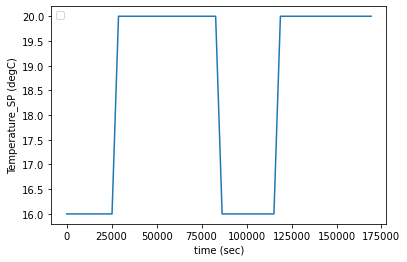

In [22]:
"""Define Temperature SP

    Assume that in normal working day, people wake up at 7.00, 
    go to work at 8.00 return home at 18.00 and go to sleep at 23.00
    
"""


"""Define Temperature SP for 1 days (24 hours) """

Night_T_SP=16
Day_T_SP=20

"""Temperature different between day and night."""
delta_T= Day_T_SP - Night_T_SP

"""Define Wake up time """
Wu_time =7;           """Wake up at 7 in the morning """
duty_wu = 23-7       

"""Go to work time/ leave the house """
Work_time = 8;           """Go to work at 8 in the morning """
duty_w   = 23-8        

"""Back to home """
back_home = 18;         """Back home at 18.00 """
duty_b   = 23-18


#-----------------------
#t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
#temp1 = signal.square(2 * np.pi* days * t,duty=duty_wu/24)
#temp1 = np.clip(temp1, 0, 1)
# add delay to array
#temp1=np.roll(temp1,Wu_time)

#----------------
t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
temp2 = signal.square(2 * np.pi* days * t,duty=duty_w/24)
temp2 = np.clip(temp2, 0, 1)
# add delay to array
temp2=np.roll(temp2,Work_time)

#___________
t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
temp3 = signal.square(2 * np.pi* days * t,duty=duty_b/24)
temp3 = np.clip(temp3, 0, 1)
# add delay to array
temp3=np.roll(temp3,back_home)

# Calculate SP

#temp4=temp1-temp2+temp3
temp4=temp2
SP=(temp4*delta_T)+Night_T_SP

SP=SP[np.newaxis]
SP=SP.T

# Plot 48 hours
plt.plot(time_t[0:48], SP[0:48])
plt.ylabel('Temperature_SP (degC)')
plt.xlabel('time (sec)')
plt.legend(loc=2)
#print(Qinternal)
SP=np.delete(SP, -1, 0)


In [23]:
#----------------
#t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
#temp2 = signal.square(2 * np.pi* days * t,duty=duty_w/24)
#temp2 = np.clip(temp2, 0, 1)
# add delay to array
#temp2=np.roll(temp2,Work_time)
#SP=(temp2*delta_T)+Night_T_SP
#SP=np.delete(SP, -1, 0)
#plt.plot(time_t[0:48], SP[0:48])

# Simulation

In [24]:
def weird_division(n, d):
    return n / d if d else 0

### Define Simulation time

In [25]:
#Define Simulation time

days_Sim = 5                        #number of simulation days

time_sim      = time[0:days_Sim*24][:,0]
Qsolar_Sim    = Qsolar[0:days_Sim*24][:,0] 
Qinternal_Sim = Qinternal[0:days_Sim*24][:,0]
T_outdoor_Sim = T_outdoor[0:days_Sim*24][:,0]

#Set point
SP_Sim=SP[0:days_Sim*24][:,0]

In [26]:
print(time_sim)

[     0.   3600.   7200.  10800.  14400.  18000.  21600.  25200.  28800.
  32400.  36000.  39600.  43200.  46800.  50400.  54000.  57600.  61200.
  64800.  68400.  72000.  75600.  79200.  82800.  86400.  90000.  93600.
  97200. 100800. 104400. 108000. 111600. 115200. 118800. 122400. 126000.
 129600. 133200. 136800. 140400. 144000. 147600. 151200. 154800. 158400.
 162000. 165600. 169200. 172800. 176400. 180000. 183600. 187200. 190800.
 194400. 198000. 201600. 205200. 208800. 212400. 216000. 219600. 223200.
 226800. 230400. 234000. 237600. 241200. 244800. 248400. 252000. 255600.
 259200. 262800. 266400. 270000. 273600. 277200. 280800. 284400. 288000.
 291600. 295200. 298800. 302400. 306000. 309600. 313200. 316800. 320400.
 324000. 327600. 331200. 334800. 338400. 342000. 345600. 349200. 352800.
 356400. 360000. 363600. 367200. 370800. 374400. 378000. 381600. 385200.
 388800. 392400. 396000. 399600. 403200. 406800. 410400. 414000. 417600.
 421200. 424800. 428400.]


In [27]:
print(len(T_outdoor_Sim))
print((Qsolar_Sim))
print(len(Qinternal_Sim))
print(len(SP_Sim))
print(len(time_sim))

120
[   0.            0.            0.            0.            0.
    0.            0.            0.            0.           12.29774608
   39.32756947  107.69101333   89.43494897   38.67126444   15.39369681
    5.26675575    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.         1401.14891457 1666.20723982
 1292.48197617  891.4543413  1030.84242846   32.59615977   22.72936975
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.         2074.42033185 2991.23742802  585.29619931
 3448.30015377 4119.27084729 2236.24683056   50.09906238    0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.     

In [28]:
from scipy.integrate import odeint
import math
import pandas as pd 


kP = 700
ki = 0
kd = 0


cpwater     = 4180
nrad        = 1.33
Crad        = 50*4180
rhowater    = 1000
volumeMid   = 0.0000015
Cmid        = cpwater*volumeMid*rhowater
Urad        = 30
Arad        = 10

# Devide by zero function
def weird_division(n, d):
    return n / d if d else 0


#Radiator model
def radiator_power(Q50, Tmid, Treturn, Tair, nrad):
    if((np.log(Tmid-Tair)-np.log(Treturn-Tair))==0):
        radiator = 0
    else:
        radiator=(Q50*((Tmid-Treturn)/((np.log(Tmid-Tair)-np.log(Treturn-Tair))*49.32))**nrad)
    return radiator


#Define model
def House_Tem(x,t,T_outdoor_Sim,Qinternal_Sim,Qsolar_Sim,SP_T, Tapwater):

# States :
    
    Tair            = x[0]   # Temperature Buffer Tank (K)
    Twall           = x[1]   # Return Temperature to Floor (K)
    Treturn         = x[2]
    Tmid            = x[3]
    Qinst           = x[4]
    
    err1      = 80 - Tmid
    err2      = SP_T-Tair
    Q50      = 12000
    
    if (err2 > 0):
        mdot = 0.2
        radiator = radiator_power(Q50, Tmid, Treturn, Tair, nrad)
    else:
        mdot = 0
        radiator = 0
           
    Qinst    = np.clip(err1*kP, 0, 12000)
    
    A1 = ((T_outdoor_Sim-Tair)/Rair_outdoor)
    A2 = ((Twall-Tair)/Rair_wall) 
    A3 = Urad*Arad*(Treturn-Tair)
    A4 = Qinternal_Sim
    A5 = CF*Qsolar_Sim
    
    B1 = ((Tair-Twall)/Rair_wall)
    B2 = (1-CF)*(Qsolar_Sim)
       
    C1 = (mdot*cpwater*(Tmid-Treturn))
    C2 = Urad*Arad*(Tair-Treturn)
    
    D1 = Qinst
    D2 = (cpwater*mdot*(Treturn-Tmid))
    D3 = Tapwater
    
  
    Tairdt   = ( A1 + A2 + A3 + A4 + A5)/(Cair)
    Twalldt  = ( B1 + B2)/Cwall
    Treturndt= ( C1 + C2)/Crad
    Tmiddt   = ( D1 + D2 - D3)/(Cmid)
    Qinstdt  = Qinst
    return [Tairdt,Twalldt,Treturndt,Tmiddt, Qinstdt]

# Initial Conditions for the States
    
Tair0    = 18  
Twall0   = 20
Treturn0 = 40
Tmid0    = 50
Qinst0    = 0


y0 = [Tair0,Twall0,Treturn0,Tmid0, Qinst0]


t = time_sim           # Define Simulation time with sampling time
#t =  np.linspace(0,3600,60)

# Model Paramters Inputs

Qsolar_Sim    =  Qsolar_Sim
Qinternal_Sim =  Qinternal_Sim
T_outdoor_sim = T_outdoor_Sim
SP_T          = SP_Sim
#Qinst_Sim     = m.Param(value=Qinst_Sim)
#SP_Sim        = SP_Sim

#Qsolar_Sim    =  np.ones(len(t))*1000
#T_outdoor_Sim = np.ones(len(t))*15
Tair   = np.ones(len(t))*Tair0
Twall  = np.ones(len(t))*Twall0
Treturn= np.ones(len(t))*Treturn0
#Qinternal_Sim = np.ones(len(t))*500
#SP_T   = np.ones(len(t))*20
Tmid   = np.ones(len(t))*Tmid0
Tapwater = np.ones(len(t))*0
Qinst = np.ones(len(t))*0


for i in range(len(t)-1):
    
    inputs = (T_outdoor_Sim[i],Qinternal_Sim[i],Qsolar_Sim[i],SP_T[i], Tapwater[i])
    ts = [t[i],t[i+1]]
    y = odeint(House_Tem,y0,ts,args=inputs)
    # Store results
   
    Tair[i+1]         = y[-1][0]
    Twall[i+1]        = y[-1][1]
    Treturn[i+1]      = y[-1][2]
    Tmid[i+1]         = y[-1][3]
    Qinst[i+1]        = y[-1][4]
   
    # Adjust initial condition for next loop
    y0 = y[-1]

    
# Construct results and save data file
data = np.hstack((t,Tair,Twall,Treturn)) # vertical stack
#data = data.T             # transpose data
np.savetxt('/kaggle/working/data.txt',data,delimiter=',')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log
/opt/conda/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [29]:
import pandas as pd
# example DataFrame to write to CSV
df = pd.DataFrame([t, Tair, Twall, Treturn, Qinst])
# set an index to avoid a 'blank' row number column and write to a file named 'submission.csv'
df.to_csv('/kaggle/working/house_model_data2.csv')

In [30]:
Tair

array([18.        , 18.01583228, 17.67445613, 17.3082638 , 16.92860489,
       16.55228959, 16.18550993, 16.00000016, 16.00000022, 17.62231319,
       18.99482952, 20.03914729, 20.        , 19.9999996 , 19.99999154,
       19.99877921, 19.99899491, 20.00000018, 20.00000047, 20.00000123,
       20.00000165, 20.00041831, 20.        , 19.99999999, 19.99999987,
       19.28222184, 18.68668818, 18.23633204, 17.90737556, 17.62496274,
       17.38896448, 17.15066568, 16.89853597, 16.69406766, 18.71629346,
       20.13457445, 20.        , 19.99999806, 19.99999864, 19.99998427,
       20.        , 20.        , 20.00000024, 20.0000002 , 20.00000094,
       20.00000109, 20.00000022, 20.00000165, 20.00000385, 19.47740662,
       19.00422482, 18.61700584, 18.30072951, 18.02151205, 17.76252655,
       17.51094114, 17.2591824 , 17.0111571 , 19.06423318, 20.14314716,
       20.        , 20.        , 20.0364101 , 20.        , 20.02386231,
       20.        , 20.        , 19.99999982, 19.99999701, 19.99

120
120
120


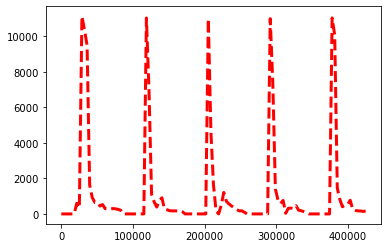

In [31]:
print(len(Qinst))
print(len(t))
print(len(Qinst))

plt.plot(t[:-1],np.diff(Qinst)/3600,'r--',linewidth=3)


In [32]:
np.savetxt('data.txt',data,delimiter=',')


In [33]:
from numpy import trapz
area = trapz(Qinst, dx=1)
print("area =", area/3600000)
print(Qinst[len(Qinst)-1]/3600000)

area = 8639.814367131044
134.49750798225068


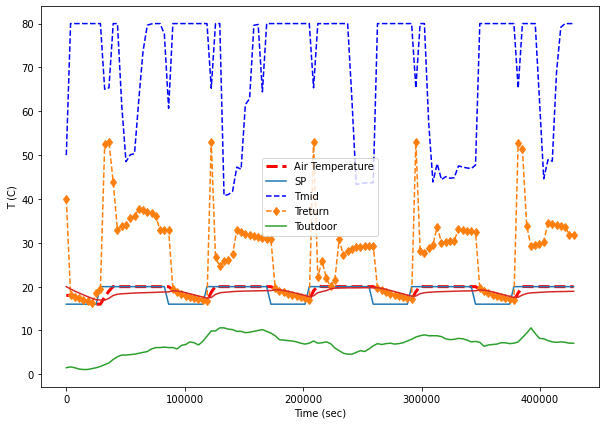

<Figure size 432x288 with 0 Axes>

In [34]:
# Plot the inputs and results
plt.figure(figsize=(10,7))
plt.plot(t,Tair,'r--',linewidth=3)
plt.plot(t,SP_T) 
plt.plot(t,Tmid,'b--') 
plt.plot(t,Treturn,'d--') 
plt.plot(t,T_outdoor_Sim)
plt.plot(t,Twall) 

plt.ylabel('T (C)')
plt.legend(['Air Temperature', 'SP','Tmid', 'Treturn', 'Toutdoor'],loc='best')
plt.xlabel('Time (sec)')
plt.figure()
plt.show()

In [35]:
print(Tair)

[18.         18.01583228 17.67445613 17.3082638  16.92860489 16.55228959
 16.18550993 16.00000016 16.00000022 17.62231319 18.99482952 20.03914729
 20.         19.9999996  19.99999154 19.99877921 19.99899491 20.00000018
 20.00000047 20.00000123 20.00000165 20.00041831 20.         19.99999999
 19.99999987 19.28222184 18.68668818 18.23633204 17.90737556 17.62496274
 17.38896448 17.15066568 16.89853597 16.69406766 18.71629346 20.13457445
 20.         19.99999806 19.99999864 19.99998427 20.         20.
 20.00000024 20.0000002  20.00000094 20.00000109 20.00000022 20.00000165
 20.00000385 19.47740662 19.00422482 18.61700584 18.30072951 18.02151205
 17.76252655 17.51094114 17.2591824  17.0111571  19.06423318 20.14314716
 20.         20.         20.0364101  20.         20.02386231 20.
 20.         19.99999982 19.99999701 19.99999737 19.99999904 19.99999614
 19.99999929 19.48872033 19.04305399 18.67673214 18.36906032 18.09180261
 17.82081468 17.56705639 17.33053789 17.11675309 18.8600262  20.067

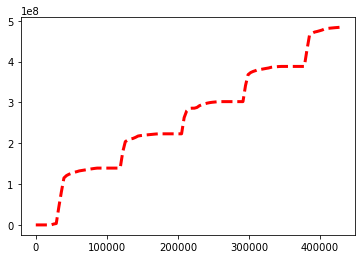

In [36]:
plt.plot(t,Qinst,'r--',linewidth=3)

In [37]:
from numpy import trapz
area = trapz(Qinst, dx=1)
print("area =", area/3600000)

area = 8639.814367131044


## Define temperature profile

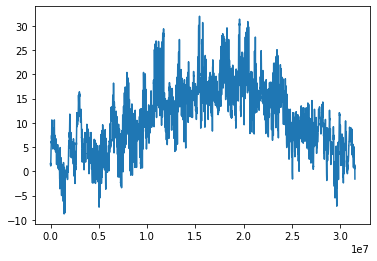

In [38]:
time_sim= time[0:365*24][:,0]
plt.plot(time_sim,T_outdoor)

In [39]:
Tem_profile=np.ones(8760)
Tem_profile=Tem_profile*14

In [40]:
Tem_out=T_outdoor.flatten()
#--------------
temp_diff=Tem_profile - Tem_out
#-----------------
sumtepdiff=np.sum(temp_diff)

# Office Building heat consumption profiel

    Assume that office are 500 m2, more than 20 employees.

    Gas consumption is 20 m3/m2 -> 500*20 =10000 m3 gas -> 9.7kwh/m3 97000 kwh.



In [41]:
kwh_per_degree=97000/sumtepdiff
print(kwh_per_degree)

3.371895770182701


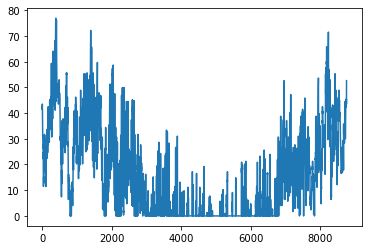

In [42]:
Q_profile= kwh_per_degree*temp_diff
Q_profile=np.clip(Q_profile, 0, 100)
plt.plot(Q_profile)

## Apartment building

* periode 1965-1974. 
* usage area: 77m2. 
* Number of residents :2.8.
* Energy label E: 1.329 m3/jaar. Energy label C: 829 m3/jaar. 
* Capaciteitsprofielen van waterverwarmingstoestellen (size M).
* Qreftap = 5,845(kwh)*365 
* Gas used(C label) = 829*9.7 - 5.845*365 = 5907.875 kwh[](http://)

In [43]:
kwh_per_degree=5907.875/sumtepdiff
print(kwh_per_degree)

0.20536844044606314


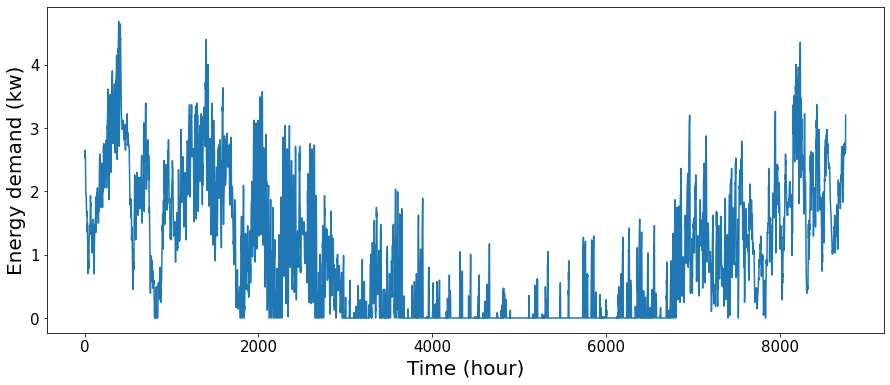

In [44]:
Q_profile= kwh_per_degree*temp_diff
Q_profile=np.clip(Q_profile, 0, 10)
plt.figure(figsize=(15, 6))
plt.ylabel('Energy demand (kw)', fontsize=20)
plt.xlabel('Time (hour)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(Q_profile)

## Hot tap water profile
capacity profile ”: a defined series of water draw-offs,

* h: time of the day
* Qtap: 'Useful energy content' (Qtap): the energy content of hot water, expressed in kWh, delivered at a temperature equal to or greater than the useful water temperature, and at water flow rates equal to or greater than the useful water flow rate.
* f: “Useful water flow rate” (f) means the minimum flow rate, expressed in liters per minute, at which hot water contributes to the reference energy, 
* Tm: 'Useful water temperature' (Tm) means the water temperature, expressed in degrees Celsius, at which hot water starts to add contribute to the reference energy
* Tp: 'Peak temperature' (Tp) means the minimum water temperature, expressed in degrees Celsius, during water abstraction must be achieved

### daily hot water profile for 1 apartment

In [45]:
Qtap = np.array([0.105, 1.4, 0.105, 0.105, 0.105, 0.105,
                 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 
                 0.315, 0.105, 0.105, 0.105, 0.105, 0.105, 
                 0.105, 0.105, 0.735, 0.105, 1.4])

f = np.array([3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
              3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 6])

Tm = np.array([25, 40, 25, 25, 25, 25, 25, 25, 25, 10, 25, 
               25, 10, 25, 25, 25, 25, 40, 40, 25, 10, 25, 40])

Tp = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 
               0, 55, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0])

time_event = np.array([7*60, (7*60+5), (7.5*60), (8*60+1), (8.25*60), (8.5*60),
                       (8.75*60), (9*60), (9.5*60), (10.5*60), (11.5*60), (11.75*60),
                       (12.75*60), (14.5*60), (15.5*60), (16.5*60), (18*60), (18.25*60),
                       (18.5*60), (19*60), (20*60), (21.25*60), (21.5*60)])

In [46]:
T_cold=np.ones(23)*10
Th_water = np.ones(len(Tm))

for i in range (0,len(Tm)):
        if Tp[i]>0:
            Th_water[i] = Tp[i]
        else:
            Th_water[i] = Tm[i]


m_tap_water = (Qtap*3600)/(4.19*(Th_water-T_cold))
Qtap_per_min = Qtap*60 # kw energy use per minutes

In [47]:
water_use_time = m_tap_water/f   # in minutes
water_use_time = np.round(water_use_time,decimals=0)
water_use_time = water_use_time.astype(int)
Ave_energy_use_perminute = Qtap_per_min/water_use_time #kw

In [48]:
temp2 = np.zeros(24*60)
k=0
for i in range (24*60):
    if k>=23:
        break
    elif i == time_event[k]:
        for f in range(water_use_time[k]):
            temp2[i+f]= Ave_energy_use_perminute[k]
        k=k+1

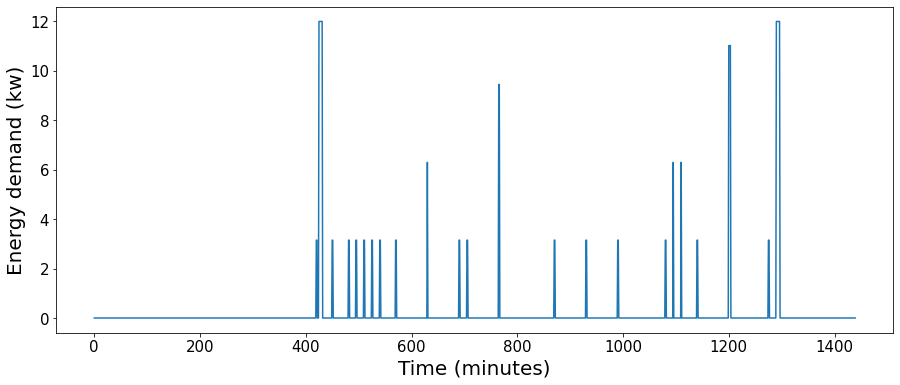

In [49]:
'''
1 days hot water profile in minutes
'''
hot_water_profile = temp2
plt.figure(figsize=(15, 6))
plt.ylabel('Energy demand (kw)', fontsize=20)
plt.xlabel('Time (minutes)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(hot_water_profile)

# D.H.W profile for a Flat with 24 apartments

**Calculation methods**
* ISSO calculatio rules (isso 55)
* 0.270 + 0.107√n + 0.00325n (n = number of appartments) 143 + 679√n + 12.8n

In [50]:
Qtap = np.array([0.105, 1.4, 0.105, 0.105, 0.105, 0.105,
                 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 
                 0.315, 0.105, 0.105, 0.105, 0.105, 0.105, 
                 0.105, 0.105, 0.735, 0.105, 1.4])

f = np.array([3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
              3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 6])

Tm = np.array([25, 40, 25, 25, 25, 25, 25, 25, 25, 10, 25, 
               25, 10, 25, 25, 25, 25, 40, 40, 25, 10, 25, 40])

Tp = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 
               0, 55, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0])

'''
time_event = np.array([7*60, (7*60+5), (7.5*60), (8*60+1), (8.25*60), (8.5*60),
                       (8.75*60), (9*60), (9.5*60), (10.5*60), (11.5*60), (11.75*60),
                       (12.75*60), (14.5*60), (15.5*60), (16.5*60), (18*60), (18.25*60),
                       (18.5*60), (19*60), (20*60), (21.25*60), (21.5*60)])
'''
# Redefine time event for hourly rate

time_event = np.array([7, (7+5/60), (7.5), (8+1/60), (8.25), (8.5),
                       (8.75), (9), (9.5), (10.5), (11.5), (11.75),
                       (12.75), (14.5), (15.5), (16.5), (18), (18.25),
                       (18.5), (19), (20), (21.25), (21.5)])

time_event_new = np.floor(time_event)

In [51]:
Qtap_per_hour = Qtap*24 # kw energy use per minutes
print(Qtap_per_hour)

[ 2.52 33.6   2.52  2.52  2.52  2.52  2.52  2.52  2.52  2.52  2.52  2.52
  7.56  2.52  2.52  2.52  2.52  2.52  2.52  2.52 17.64  2.52 33.6 ]


In [52]:
#temp = np.zeros(24)
temp1 = np.zeros(24)

n=0
i=0
for k in range (24):
    temp1[k] = 0
    #print(temp1)

    while n == time_event_new[i]:  
        temp= Qtap_per_hour[i]
                #print(temp)
        temp1[k] =temp1[k]+temp
        if i >21:
            break
        else:
            i=i+1
    n=n+1

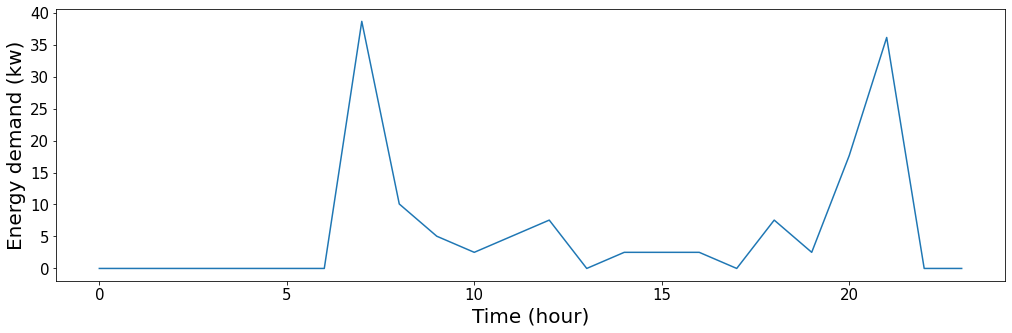

In [53]:
hot_water_profile = temp1
plt.figure(figsize=(17, 5))
plt.ylabel('Energy demand (kw)', fontsize=20)
plt.xlabel('Time (hour)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(hot_water_profile)

In [54]:
Q_building_profile = (hot_water_profile.tolist()*365) + Q_profile*24

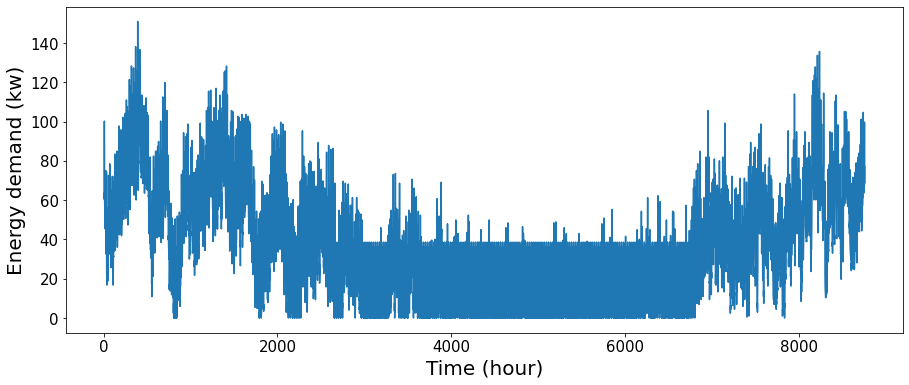

In [55]:
plt.figure(figsize=(15, 6))
plt.ylabel('Energy demand (kw)', fontsize=20)
plt.xlabel('Time (hour)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(Q_building_profile)

## Correction methods for average enery use time.

* The calculation show that the average hot water use time is not always for an hour.
* The correction will spread the energy for an hours use time. 

In [56]:
#qtaph1= 0.270 + 0.107*math.sqrt(1) + 0.00325*1
#qtap24= 0.270 + 0.107*math.sqrt(24) + 0.00325*24
qtaph1= 243 + 679*math.sqrt(1) + 12.8*1
qtap24= 243 + 679*math.sqrt(24) + 12.8*1
ratio = qtap24/qtaph1
#print(ratio)
fnew=f*ratio
#print(fnew)

In [57]:
T_cold=np.ones(23)*10
Th_water = np.ones(len(Tm))
for i in range (0,len(Tm)):
        if Tp[i]>0:
            Th_water[i] = Tp[i]
        else:
            Th_water[i] = Tm[i]


m_tap_water = (Qtap*3600)/(4.19*(Th_water-T_cold))
water_use_time = m_tap_water*24/fnew   # in minutes
#print(water_use_time)

In [58]:
#temp = np.zeros(24)
temp1 = np.zeros(24)
n=0
i=0
for k in range (24):
    temp1[k] = 0
    #print(temp1)
    #print(n)
    while n == time_event_new[i]:  
        temp= water_use_time[i]
        temp1[k] =temp1[k]+temp
        if i >21:
            break
        else:
            i=i+1
    n=n+1

In [59]:
water_use_timenew = temp1/60  #in hours
print(water_use_timenew)

[0.         0.         0.         0.         0.         0.
 0.         1.25558038 0.83705359 0.41852679 0.1046317  0.41852679
 0.2092634  0.         0.2092634  0.2092634  0.2092634  0.
 0.41852679 0.2092634  0.36621095 0.90680805 0.         0.        ]


In [60]:
'Shift the extra time to the next hour'

temp2=water_use_timenew
for i in range (24):
    if temp2[i] >1:
        temp2[i+1]= temp2[i+1] + (temp2[i]-1)
        temp2[i]=1        
        #print(temp2)
    else: 
        temp2[i]=temp2[i]

print(temp2)

[0.         0.         0.         0.         0.         0.
 0.         1.         1.         0.51116077 0.1046317  0.41852679
 0.2092634  0.         0.2092634  0.2092634  0.2092634  0.
 0.41852679 0.2092634  0.36621095 0.90680805 0.         0.        ]


In [61]:
hot_water_profile_cor = hot_water_profile*temp2
print(hot_water_profile_cor)

[ 0.          0.          0.          0.          0.          0.
  0.         38.64       10.08        2.57625026  0.26367188  2.10937504
  1.58203128  0.          0.52734376  0.52734376  0.52734376  0.
  3.16406257  0.52734376  6.45996107 32.75390693  0.          0.        ]


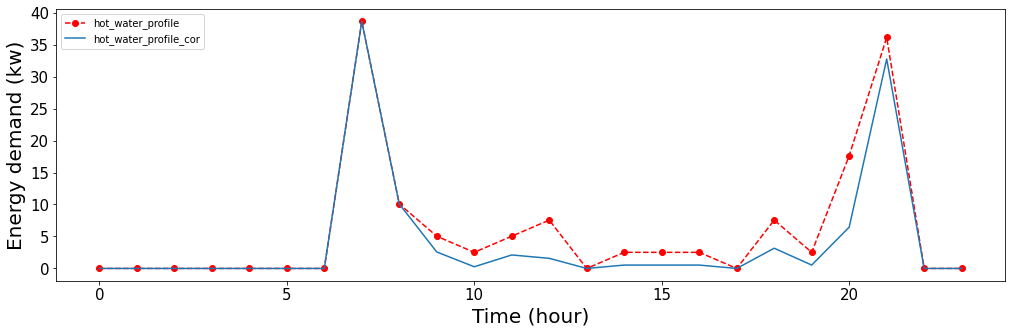

In [62]:
plt.figure(figsize=(17, 5))
plt.ylabel('Energy demand (kw)', fontsize=20)
plt.xlabel('Time (hour)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(hot_water_profile,'r--o',label="hot_water_profile")
plt.plot(hot_water_profile_cor,label="hot_water_profile_cor")
plt.legend()
plt.show()

In [63]:
Q_building_profile = (hot_water_profile_cor.tolist()*365) + Q_profile*24

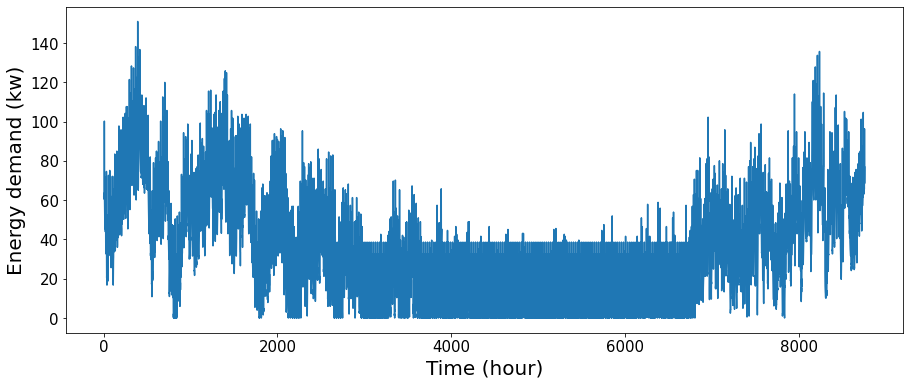

In [64]:
plt.figure(figsize=(15, 6))
plt.ylabel('Energy demand (kw)', fontsize=20)
plt.xlabel('Time (hour)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(Q_building_profile)

In [65]:
#!pip list

